# Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

df = pd.read_csv("cardio_train.csv", sep=";")



# Clean data

In [2]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

if 'cardio' in df:
    y = df['cardio'].values
    del df['cardio']
    X = df.values


# Model Variable Selection Options

1. 'ap_hi' (highest co-relation)
2. 'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
3. 'bmi', 'age', ‘bp’, 'cholesterol'
4. ‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol'
5. 'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active', 'weight' (all variable)



In [ ]:
some more explanation

## train test split

In [3]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model (ap_hi only)

### Not Scaled

In [4]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73474949 0.73226494 0.73699703]


### Scaled

In [5]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

C:\Users\parit\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  retur

[0.73560513 0.73413289 0.73557645]


## SVM using BMI, age, ap_hi, ap_lo, cholesterol

### Not Scaled

In [9]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.64436945 0.56968912 0.71217683]


### Scaled

In [180]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77296258 0.7736283  0.78275248]


# Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV

### SVM

In [18]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SGDClassifier())]),
             param_grid=[{'classifier__alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
                          'classifier__loss': ['modified_huber'],
                          'classifier__penalty': ['l1', 'l2', 'elasticnet']}],
             scoring='roc_auc')

In [19]:
clf.best_params_

{'classifier__alpha': 0.05,
 'classifier__loss': 'modified_huber',
 'classifier__penalty': 'l1'}

In [196]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


Best auc: 0.777694 using {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.772528 (0.005303) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.772481 (0.006019) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.771480 (0.004149) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776109 (0.002568) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.776786 (0.003735) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.777035 (0.003645) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776539 (0.002835) with: {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.7772

## Probability Calibration

In [197]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77982185 0.77476165 0.77906842]


## ROC

SVM Model ROC AUC=0.769


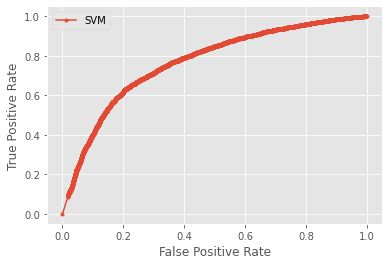

In [198]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [199]:
svm_probs

array([0.43619674, 0.56858624, 0.37566759, ..., 0.34705585, 0.45247799,
       0.75793575])

In [200]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))


alpha 0.000000 : accuracy=0.560
alpha 0.100000 : accuracy=0.560
alpha 0.200000 : accuracy=0.562
alpha 0.300000 : accuracy=0.608
alpha 0.400000 : accuracy=0.689
alpha 0.500000 : accuracy=0.707
alpha 0.600000 : accuracy=0.683
alpha 0.700000 : accuracy=0.622
alpha 0.800000 : accuracy=0.561
alpha 0.900000 : accuracy=0.511


### tune a little finer

In [201]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



alpha 0.400000 : accuracy=0.689
alpha 0.410000 : accuracy=0.694
alpha 0.420000 : accuracy=0.699
alpha 0.430000 : accuracy=0.703
alpha 0.440000 : accuracy=0.705
alpha 0.450000 : accuracy=0.708
alpha 0.460000 : accuracy=0.710
alpha 0.470000 : accuracy=0.710
alpha 0.480000 : accuracy=0.709
alpha 0.490000 : accuracy=0.708
alpha 0.500000 : accuracy=0.707
alpha 0.510000 : accuracy=0.706
alpha 0.520000 : accuracy=0.707
alpha 0.530000 : accuracy=0.705
alpha 0.540000 : accuracy=0.705
alpha 0.550000 : accuracy=0.703
alpha 0.560000 : accuracy=0.701
alpha 0.570000 : accuracy=0.695
alpha 0.580000 : accuracy=0.692
alpha 0.590000 : accuracy=0.688


### Logistic Regression

In [6]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [7]:
#data setup

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Data Cleanup¶

#### Weight and Height

In [8]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

#### BP Clean up

In [9]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [10]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

### Add bp

In [11]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below

In [13]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [14]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


### Options
Following are combo I selected based on high correlation and removing

'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
'ap_hi' (highest co-relation)
'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)

In [15]:
df=df1

In [16]:
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','gluc','smoke','alco','active','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

In [17]:
#df1.head(5)

,age,ap_hi,ap_lo,cholesterol,bmi
1,20228,140,90,3,34.927679
2,18857,130,70,3,23.507805
3,17623,150,100,1,28.710479
5,21914,120,80,2,29.384676
6,22113,130,80,3,37.729725


In [19]:
#df.head(5)

### Option 1 model

In [20]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [21]:
#make a grid search for logistic regression


param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\de

{'mean_fit_time': array([1.13633084, 1.00117302, 1.24963212, 1.06326763, 1.4947203 ,
        0.74481932, 0.57179991, 0.83711425, 0.96098264, 0.88291057]),
 'std_fit_time': array([0.19599763, 0.35013641, 0.37566614, 0.02926901, 0.16095971,
        0.27037105, 0.26492049, 0.63907737, 0.62121947, 0.56914189]),
 'mean_score_time': array([0.01731292, 0.01359653, 0.01662254, 0.01372441, 0.02104044,
        0.01151768, 0.00826097, 0.01566847, 0.01730092, 0.01324264]),
 'std_score_time': array([0.00397366, 0.00540765, 0.00397869, 0.00513832, 0.00100068,
        0.00259998, 0.00047408, 0.00308104, 0.00376869, 0.00584744]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2',
                    'l2'],
              mask=

In [22]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.774869 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774869 (0.002382) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774771 (0.002418) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774727 (0.002337) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.774746 (0.002407) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.774768 (0.002305) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.638711 (0.013316) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638701 (0.013310) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.681950 (0.065536) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.681949 (0.065536) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.681949 (0.065536) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [23]:

from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object


In [24]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7829547933192589
confusion matrix
 [[3456 1276]
 [1670 4209]]
====Iteration 1  ====
auc 0.7754650624424138
confusion matrix
 [[3376 1312]
 [1690 4233]]
====Iteration 2  ====
auc 0.7685047471625793
confusion matrix
 [[3365 1360]
 [1696 4190]]


#### train test split

In [25]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

#### Logistic Regression Scaled

In [26]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [27]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\de

{'mean_fit_time': array([0.14850839, 0.52759393, 0.20345561, 0.55784543, 0.19016083,
        0.54111687, 0.1761651 , 0.60507512, 0.18359399, 0.61951089,
        0.13863087, 0.64345797, 0.45117307, 0.16854954, 0.74270328,
        0.52776082, 0.16951672, 0.75927965, 0.54756435, 0.18110339,
        0.76051315, 0.36976258, 0.11459931, 0.75434391, 0.60609031]),
 'std_fit_time': array([0.02457383, 0.07212964, 0.02330939, 0.01973177, 0.00335044,
        0.03443176, 0.00698294, 0.04338684, 0.03389014, 0.0577429 ,
        0.03420258, 0.2195953 , 0.06371536, 0.02378538, 0.02790232,
        0.05588873, 0.0049283 , 0.04496753, 0.01357849, 0.00762215,
        0.05408066, 0.03968448, 0.02429979, 0.02349125, 0.03094362]),
 'mean_score_time': array([0.00908422, 0.01424702, 0.01928926, 0.01858425, 0.02127004,
        0.01599201, 0.01230033, 0.0159208 , 0.01322508, 0.01127847,
        0.01539556, 0.01201558, 0.01624791, 0.01328397, 0.01759481,
        0.01326013, 0.01230065, 0.02023172, 0.01894561, 0.01

In [28]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.775434 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775432 (0.002879) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775434 (0.002878) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775422 (0.002882) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775422 (0.002881) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775421 (0.002881) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775421 (0.002881) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775421 (0.002881) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775421 (0.002881) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775421 (0.002882)

In [29]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7690173795950215
[0.71718028 0.70737913 0.71388182]


In [30]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7787723787464775
confusion matrix
 [[3424 1306]
 [1702 4179]]
====Iteration 1  ====
auc 0.7766689020714688
confusion matrix
 [[3458 1314]
 [1706 4133]]
====Iteration 2  ====
auc 0.7689773257589287
confusion matrix
 [[3342 1349]
 [1752 4168]]


In [31]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [32]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [33]:
clf.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [34]:
model=clf.best_estimator_.fit(X,y)

In [35]:
model.named_steps["classifier"].coef_

array([[0.29730359, 0.895704  , 0.12862789, 0.28280883, 0.10074451]])

#### precision recall curve

Logistic: ROC AUC=0.769


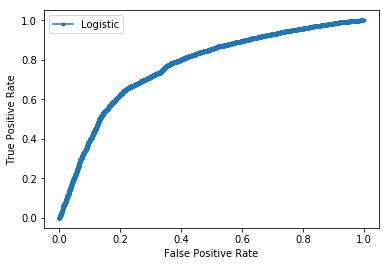

In [36]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Option 3 model

In [83]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Cleanup

#### Weight and Heigh

In [84]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

#### BP Clean up

In [85]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [86]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp

In [87]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


In [88]:
# Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [89]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [90]:
# df1.head(5)

### Options 3
Following are combo I selected based on high correlation and removing

'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
'ap_hi' (highest co-relation)
'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)

In [91]:
df=df1
df1
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

In [92]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

C:\Users\parit\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any mor

{'mean_fit_time': array([2.23018305, 2.54380488, 2.12472892, 1.7286675 , 2.29781906,
        0.7234079 , 0.67552582, 0.77360185, 0.42936484, 0.58078138]),
 'std_fit_time': array([0.85776811, 0.49020266, 0.39763073, 0.26371298, 0.68896882,
        0.18729209, 0.22380029, 0.28650149, 0.00422998, 0.26058274]),
 'mean_score_time': array([0.01946378, 0.01161702, 0.01521269, 0.0116206 , 0.01758536,
        0.01559059, 0.0119702 , 0.01063728, 0.0103337 , 0.01331186]),
 'std_score_time': array([0.00318901, 0.0069068 , 0.00343195, 0.0055378 , 0.00477862,
        0.00129262, 0.00423109, 0.0030843 , 0.00629732, 0.00365406]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2',
                    'l2'],
              mask=

In [94]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.779661 using {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779512 (0.004000) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779661 (0.004164) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779617 (0.004151) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.779542 (0.004107) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.779472 (0.003934) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.642979 (0.025875) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.642449 (0.025454) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638260 (0.021932) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.630397 (0.018902) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638252 (0.021926) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [96]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [97]:
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [98]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7760096265232266
confusion matrix
 [[3413 1337]
 [1699 4162]]
====Iteration 1  ====
auc 0.7739519469347773
confusion matrix
 [[3350 1327]
 [1740 4194]]
====Iteration 2  ====
auc 0.7742651046124266
confusion matrix
 [[3357 1264]
 [1767 4223]]


#### train test split

In [99]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

In [100]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#### Logistic Regression Scaled

In [101]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [102]:
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_

C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\parit\Anaconda\lib\site-packages\sklearn\utils\de

{'mean_fit_time': array([0.25365353, 0.83486994, 0.15757902, 0.72542707, 0.22569505,
        0.78545435, 0.24665689, 0.74967806, 0.26828988, 0.81947478,
        0.13663451, 0.84688743, 0.68685714, 0.18023849, 0.99644303,
        0.71114993, 0.13461121, 0.99999277, 0.84047906, 0.0728054 ,
        0.93457731, 0.71811438, 0.18915884, 1.06844449, 0.99353941]),
 'std_fit_time': array([0.03692751, 0.12044648, 0.01585361, 0.07668434, 0.02440388,
        0.05604756, 0.00981837, 0.03971338, 0.00563256, 0.0509568 ,
        0.03118987, 0.27463422, 0.04416542, 0.02685969, 0.06286471,
        0.07949175, 0.00817267, 0.04873309, 0.0550668 , 0.02386716,
        0.21794282, 0.02649502, 0.00782439, 0.06449792, 0.08747253]),
 'mean_score_time': array([0.01196893, 0.01261576, 0.01200112, 0.01661587, 0.01630004,
        0.02093355, 0.01382693, 0.01929681, 0.02057894, 0.01862303,
        0.01466219, 0.01308179, 0.02160978, 0.01757741, 0.01771577,
        0.01823115, 0.01662087, 0.01761937, 0.01261822, 0.00

In [103]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.778420 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778418 (0.004499) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778420 (0.004498) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778398 (0.004500) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778398 (0.004500) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778395 (0.004500) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778397 (0.004500) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778396 (0.004500) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778396 (0.004500) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778395 (0.004500)

In [104]:

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7742956684281203
[0.71473    0.71746301 0.7221751 ]


In [105]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7766636992771293
confusion matrix
 [[3272 1278]
 [1787 4274]]
====Iteration 1  ====
auc 0.7779139340127131
confusion matrix
 [[3373 1302]
 [1710 4226]]
====Iteration 2  ====
auc 0.7814293307063339
confusion matrix
 [[3362 1305]
 [1705 4239]]


In [106]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [107]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [108]:
clf.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [109]:
model=clf.best_estimator_.fit(X,y)

In [110]:
model.named_steps["classifier"].coef_

array([[ 0.2956479 ,  0.9020887 ,  0.12967055,  0.32368209, -0.07845395,
        -0.03661296, -0.04821579, -0.09435271,  0.10182013]])

#### precision recall curve

Logistic: ROC AUC=0.781


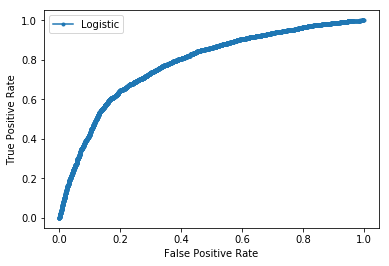

In [111]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##### Follwoing is the summary of Analysis that was run on Logistic Regression and SVM with Five options in unscaled and scaled options.

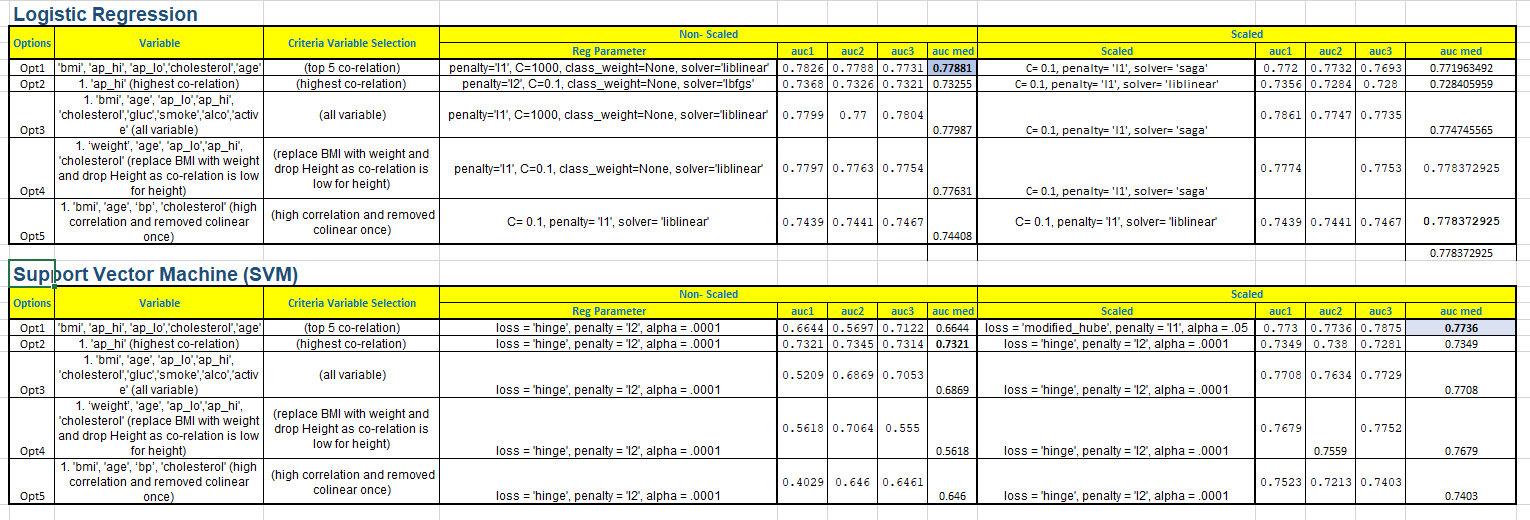

# SVM

Our favorite SVM model is Option 1 Scaled

Confusion matrix / classification report  - Ellen

precision, recall, f1, accuracy - Ellen

explain the hyperparameters - Tina

### Interpretation

Make SVC from subsampled set - Tina

Ellen

# Logistic regression

Our favorite Logistic model is Option 1 Unscaled

Confusion matrix / classification report 

precision, recall, f1, accuracy

explain the hyperparameters - Paritosh, Fabio

### Weights Interpretation

Fabio

# Advantages and Disadvantages

Our favorite model overall is the Logistic regression option 1 unscaled.

Is one better about training time?

Is one better from accuracy?